## Setup

Requirements:


In [40]:
#Load Packages
import pandas as pd
import numpy as np
import patsy as pt
import plotly.express as px
import nbformat
import plotly as py

In [41]:
#Load Data
data = pd.read_csv("amazon-purchases.csv")
survey_data = pd.read_csv("survey.csv")

# Data Pre-Processing

In [42]:
#Add a prime purchase column to the data

#Create a list with prime days inside it
prime_days = ["2022-07-12", "2022-07-13", "2021-06-21", "2021-06-22", "2020-10-13", "2020-10-14", "2019-07-15", "2019-07-16", "2018-07-17", "2018-07-18",]

prime_purchase = []
for i in data["Order Date"]:
    if i in prime_days:
        prime_purchase.append(1)
    else:
        prime_purchase.append(0)
data["Prime Purchase"] = prime_purchase

In [43]:
#Use prime purchase data to create a prime day customer list
prime_day_customer = []
for i in range(len(data)):
    if data["Prime Purchase"][i] == 1:
        prime_day_customer.append(data["Survey ResponseID"][i])
prime_day_customer = set(prime_day_customer)

prime_customer = []
for i in data["Survey ResponseID"]:
    if i in prime_day_customer:
        prime_customer.append(1)
    else:
        prime_customer.append(0)

data["Prime Customer"] = prime_customer

In [44]:
# Merge the purchase data with customer surveys on 'Survey ResponseID'
merged_data = pd.merge(data, survey_data, on='Survey ResponseID', how='inner')

# Display the first few rows of the merged dataframe
print(merged_data.shape, data.shape, survey_data.shape)

(1850717, 32) (1850717, 10) (5027, 23)


In [45]:
subset_data = merged_data[(merged_data['Q-demos-gender'] == 'Female') & (merged_data['Q-demos-age'] == '35 - 44 years') & (merged_data['Prime Customer'] == 1)]

Data exploration

In [46]:
unique_responses_by_gender = merged_data.groupby('Q-demos-gender')['Survey ResponseID'].nunique()
print(unique_responses_by_gender)

Q-demos-gender
Female               2589
Male                 2311
Other                 116
Prefer not to say      11
Name: Survey ResponseID, dtype: int64


In [47]:
subset_data['Order Date'].max()
record = subset_data[merged_data['Order Date'] == subset_data['Order Date'].max()]
record

C:\Users\nicko\AppData\Local\Temp\ipykernel_18320\4112819008.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
1053948,2023-03-22,0.17,16.0,MS,Photo Prints – Matte – Standard Size (4x6),B071RWC7RC,WALL_ART,R_3HAk4tN4hE1Arcm,0,1,...,No,Yes,No,No,"Became pregnant,Had a child",Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,No,Yes


In [48]:
subset_data.columns

Index(['Order Date', 'Purchase Price Per Unit', 'Quantity',
       'Shipping Address State', 'Title', 'ASIN/ISBN (Product Code)',
       'Category', 'Survey ResponseID', 'Prime Purchase', 'Prime Customer',
       'Q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education',
       'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation',
       'Q-demos-state', 'Q-amazon-use-howmany', 'Q-amazon-use-hh-size',
       'Q-amazon-use-how-oft', 'Q-substance-use-cigarettes',
       'Q-substance-use-marijuana', 'Q-substance-use-alcohol',
       'Q-personal-diabetes', 'Q-personal-wheelchair', 'Q-life-changes',
       'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use',
       'Q-census-use', 'Q-research-society'],
      dtype='object')

In [50]:
# Convert 'Order Date' to datetime
subset_data['Order Date'] = pd.to_datetime(subset_data['Order Date'])

# Group by 'Order Date' and sum the 'Purchase Price Per Unit'
transaction_totals = subset_data.groupby(['Order Date', 'Q-demos-gender'])['Purchase Price Per Unit'].sum().reset_index()

# Plot the time series
px.line(transaction_totals, x='Order Date', y='Purchase Price Per Unit', title='Transaction Totals Over Time')

C:\Users\nicko\AppData\Local\Temp\ipykernel_18320\758613859.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
subset_data['Order Date'].max()

Timestamp('2023-03-22 00:00:00')

In [53]:
subset_data.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
2748,2018-01-18,6.99,1.0,KS,NaN,B077D6Z153,NaN,R_0Arj0ePpTnReV1v,0,1,...,No,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes
2749,2018-01-22,28.87,1.0,KS,MidWest Foldable Metal Dog Exercise Pen / Pet ...,B002908DX0,PET_PLAYPEN,R_0Arj0ePpTnReV1v,0,1,...,No,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes
2750,2018-01-26,19.99,1.0,KS,White Noise Sleep Sound Machine for Adults | S...,B01H6WXUX8,NOISE_MACHINE,R_0Arj0ePpTnReV1v,0,1,...,No,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes
2751,2018-02-10,7.95,1.0,KS,"GoTags Stainless Steel Pet ID Tags, Personaliz...",B00BJLS55G,LABEL,R_0Arj0ePpTnReV1v,0,1,...,No,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes
2752,2018-02-23,4.94,1.0,KS,Ateco 3.5-Inch Round Stainless Steel Cutter,B002A8QOUU,COOKIE_CUTTER,R_0Arj0ePpTnReV1v,0,1,...,No,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes


# Clustering for Feature Selection

K-means for purchase quantity and purchase totals

In [65]:
#Group by survey response id and count the number of prime purchases and sum the price per unit
prime_users = subset_data.groupby("Survey ResponseID").agg({"Prime Purchase":"sum", "Purchase Price Per Unit":"sum"})
#Left join prime purchases with survey data
print(prime_users.shape)
# Rename the column
prime_users.rename(columns={'Purchase Price Per Unit': 'Purchase Totals'}, inplace=True)

(431, 2)


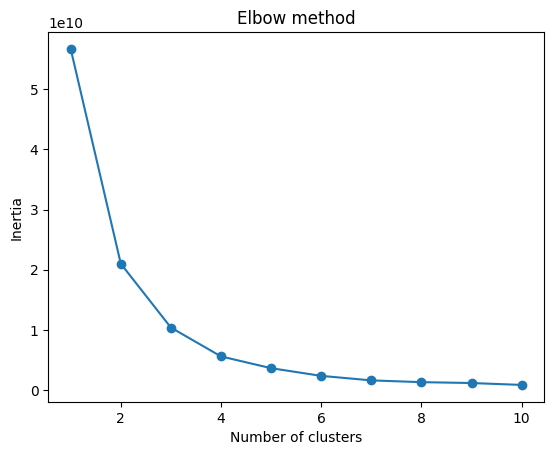

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_data = list(zip(prime_users['Prime Purchase'], prime_users['Purchase Totals']))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(k_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

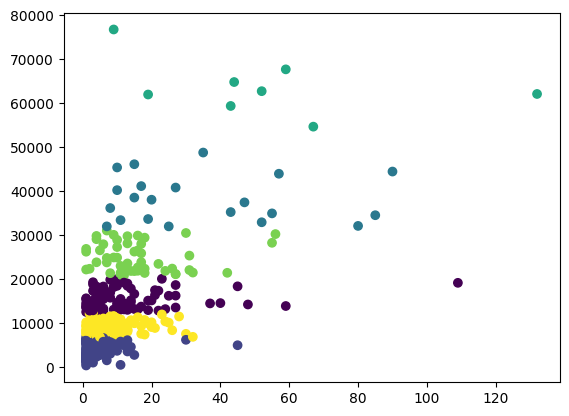

In [73]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(k_data)

plt.scatter(prime_users['Prime Purchase'], prime_users['Purchase Totals'], c=kmeans.labels_)
plt.show()

In [75]:
# Display the cluster centers
print("Cluster Centers:")
print(kmeans.cluster_centers_)

# Display the labels assigned to each data point
print("Cluster Labels:")
print(kmeans.labels_)

prime_users['cluster'] = kmeans.labels_

Cluster Centers:
[[1.24361702e+01 1.55513377e+04]
 [4.57746479e+00 4.26274035e+03]
 [3.46666667e+01 3.82174967e+04]
 [5.31250000e+01 6.37918450e+04]
 [1.60196078e+01 2.50018106e+04]
 [8.59130435e+00 9.34587783e+03]]
Cluster Labels:
[1 4 2 5 5 5 1 1 5 1 5 1 5 2 2 1 0 5 4 0 1 0 1 0 1 2 1 5 1 0 5 4 1 0 3 2 5
 5 0 0 5 1 3 1 1 5 0 1 1 1 5 1 0 1 5 0 1 5 1 4 5 0 0 5 4 0 0 4 5 1 4 5 0 0
 0 4 5 1 1 5 1 1 1 1 1 3 5 5 4 0 5 2 5 0 1 0 5 0 0 1 0 4 1 0 4 1 4 0 1 5 2
 0 4 4 1 1 5 5 0 5 0 5 5 0 4 1 5 0 5 5 1 5 4 0 0 0 1 5 5 5 4 1 4 4 1 0 5 1
 4 5 1 5 1 0 0 5 0 5 4 1 1 1 0 0 0 1 3 1 4 2 5 1 1 1 4 1 0 1 5 5 1 2 1 5 4
 2 1 4 1 5 2 1 5 0 4 5 5 1 5 1 0 1 5 5 1 0 1 1 1 1 1 5 0 1 4 0 4 0 5 1 1 1
 1 1 5 0 1 5 0 5 5 5 1 5 5 1 2 5 0 4 5 1 1 5 1 4 5 0 0 5 5 2 5 0 4 1 0 0 0
 0 5 1 5 1 1 4 1 1 0 1 0 0 4 1 0 5 5 1 0 3 5 5 1 4 1 1 3 5 2 1 1 2 0 4 5 2
 0 5 0 0 0 1 0 5 1 1 1 5 0 0 4 0 0 4 5 0 4 0 1 1 5 1 5 3 0 5 4 0 1 0 2 0 1
 5 0 5 1 1 5 4 1 4 1 5 0 5 3 1 5 5 5 0 1 2 2 1 5 1 0 4 5 0 5 4 5 4 1 1 5 1
 5 1 1 0 1 4 1 1 1

In [ ]:
# Merge the subset_data with prime_users to map the cluster labels
subset_data_with_clusters = pd.merge(subset_data, prime_users[['cluster']], on='Survey ResponseID', how='left')

# Display the first few rows of the resulting dataframe
subset_data_with_clusters.head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID,Prime Purchase,Prime Customer,...,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,cluster
0,2018-01-18,6.99,1.0,KS,NaN,B077D6Z153,NaN,R_0Arj0ePpTnReV1v,0,1,...,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes,5
1,2018-01-22,28.87,1.0,KS,MidWest Foldable Metal Dog Exercise Pen / Pet ...,B002908DX0,PET_PLAYPEN,R_0Arj0ePpTnReV1v,0,1,...,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes,5
2,2018-01-26,19.99,1.0,KS,White Noise Sleep Sound Machine for Adults | S...,B01H6WXUX8,NOISE_MACHINE,R_0Arj0ePpTnReV1v,0,1,...,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes,5
3,2018-02-10,7.95,1.0,KS,"GoTags Stainless Steel Pet ID Tags, Personaliz...",B00BJLS55G,LABEL,R_0Arj0ePpTnReV1v,0,1,...,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes,5
4,2018-02-23,4.94,1.0,KS,Ateco 3.5-Inch Round Stainless Steel Cutter,B002A8QOUU,COOKIE_CUTTER,R_0Arj0ePpTnReV1v,0,1,...,No,Yes,No,"Divorce,Moved place of residence",No,No,No,I don't know,Yes,5


In [76]:
# Group by cluster and category, then sum the purchase totals
cluster_category_totals = subset_data_with_clusters.groupby(['cluster', 'Category'])['Purchase Price Per Unit'].sum().reset_index()

# Sort the totals within each cluster and select the top 5 categories
top_categories_per_cluster = cluster_category_totals.sort_values(['cluster', 'Purchase Price Per Unit'], ascending=[True, False]).groupby('cluster').head(5)

# Display the result
top_categories_per_cluster

,cluster,Category,Purchase Price Per Unit
3,0,ABIS_BOOK,35530.56
965,0,PET_FOOD,26581.72
1151,0,SHIRT,17526.64
612,0,GIFT_CARD,16745.77
904,0,NOTEBOOK_COMPUTER,15460.94
1495,1,ABIS_BOOK,36296.64
2094,1,GIFT_CARD,22350.74
2385,1,NUTRITIONAL_SUPPLEMENT,19141.07
2443,1,PET_FOOD,18622.82
2629,1,SHOES,15433.35


In [79]:
subset_data_with_clusters.shape

(287930, 33)

In [77]:
subset_data_with_clusters.to_csv('subset_data_with_clusters.csv', index=False)

Clustering for dimension reduction

# Specify and Prepare the Model Type

In [ ]:
#Exponential Smoothing

In [ ]:
#GAMs
from pygam import LinearGAM, s, f
import pandas as pd
import patsy as pt
import numpy as np
from plotly import subplots
import plotly.offline as py
import plotly.graph_objs as go

In [88]:
subset_data_with_clusters.rename(columns={'Order Date': 'Date', 'Shipping Address State': 'State'}, inplace=True)
subset_data_with_clusters.columns

Index(['Date', 'Purchase Price Per Unit', 'Quantity', 'State', 'Title',
       'ASIN/ISBN (Product Code)', 'Category', 'Survey ResponseID',
       'Prime Purchase', 'Prime Customer', 'Q-demos-age', 'Q-demos-hispanic',
       'Q-demos-race', 'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft',
       'Q-substance-use-cigarettes', 'Q-substance-use-marijuana',
       'Q-substance-use-alcohol', 'Q-personal-diabetes',
       'Q-personal-wheelchair', 'Q-life-changes', 'Q-sell-YOUR-data',
       'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use',
       'Q-research-society', 'cluster'],
      dtype='object')

In [94]:
# Generate x and y matrices
eqn = """Quantity ~ -1 + Date + State + 
Category + cluster"""
y, x = pt.dmatrices(eqn, data=subset_data_with_clusters)

# Convert sparse matrix to dense matrix
x = x.toarray()

# Initialize and fit the model
gam = LinearGAM(s(0) + f(1) + f(2) + f(3))
gam = gam.gridsearch(x, y)

AttributeError: 'DesignMatrix' object has no attribute 'toarray'

In [ ]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# As usual, Patsy makes data prep easier
y = data['Prime Customer']
x = data[['Purchase Price Per Unit','Quantity']]

x, xt, y, yt = train_test_split(x, y, 
		test_size=0.33, random_state=42)

In [ ]:
#Random Forest

In [ ]:
#XGBoost

In [ ]:
##NN

In [ ]:
#Bayesian

# Train Models

In [ ]:
#Decision Tree

# Create the model and fit it
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(x, y)

DecisionTreeClassifier(max_depth=5)

# Prediction & Validation

In [ ]:
#Decision Tree "clf"

print("\n\nIn-sample accuracy: %s%%\n\n" 
 % str(round(100*accuracy_score(y, clf.predict(x)), 2)))
print("\n\nOut-of-sample accuracy: %s%%\n\n"
%str(round(100*accuracy_score(yt, clf.predict(xt)), 2)))



In-sample accuracy: 86.96%




Out-of-sample accuracy: 87.02%


